In [1]:
import os
import shutil
import glob
import zipfile

import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
from PIL import Image
import cv2

import math

# 1. 데이터 경로 변경 및 통합

## 1-1) 이미지 압축해제 후 경로 변경 (1번만 수행)

In [2]:
ba_path="/Users/eunha/Desktop/골밀도데이터/BoneAge/"
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

#xlsx파일과 zip파일 경로 추출
xls_path=glob.glob(ba_path+"/*.xlsx")
zip_path=glob.glob(ba_path+"/*.zip")

In [3]:
#zip파일 압축 해제 후 위치 변경
for zip in zip_path:
    zipfile.ZipFile(zip).extractall(data_path+"images")

In [4]:
#이중 폴더 내 이미지 꺼내기
infolder_path=glob.glob(data_path+"images"+"/BA*")
for in_path in infolder_path:
    tmp=os.listdir(in_path)
    for i in tmp:
        os.rename(in_path+"/"+i,data_path+"images/"+i)
    
    os.rmdir(in_path)

## 1-2) xlsx 파일 합친 후 저장 (1번만 수행)

In [5]:
#xlsx파일 읽어서 합치기
df=pd.DataFrame()
for xlsx in xls_path:
    sub=pd.read_excel(xlsx)
    
    id= pd.DataFrame([int(re.findall(r'\d+',str(x))[0]) for x in sub["No."]])
    ba=(sub["BA 1"]+sub["BA 2"])/2
    gender=sub["성별"]-1
    
    tmp=pd.concat([id,ba,gender],axis=1,ignore_index=True)
    df=pd.concat([df,tmp],axis=0,ignore_index=True)

df.columns=["ID","BoneAge","Gender"]

In [7]:
#labeling 데이터 저장
df.to_excel(data_path+"clin_info.xlsx",index=False)

# 2. 1차 이미지 전처리

(1번 코드 실행한 경우 여기부터 수행)  
ROI 구간당 전처리하기 전 전체 이미지 전처리 수행

## 2-1) 라벨링 데이터 불러오기

In [2]:
#label 정보 불러오기
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

df=pd.read_excel(data_path+"clin_info.xlsx")

## 2-2) 샘플 이미지로 전처리 결과 확인

In [3]:
#샘플 이미지 흑백으로 불러오기
img_path=data_path+"images/014_M.jpg"
img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
img.shape #shape 확인

(1296, 1060)

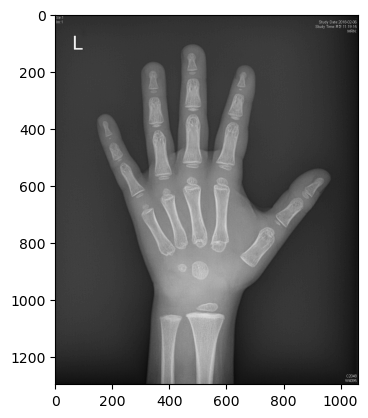

In [4]:
#원본 이미지 확인
plt.imshow(img,"gray")

### Resize

In [5]:
#이미지 가로 세로 비율 확인
img.shape[0]/img.shape[1]

1.2226415094339622

In [6]:
#이미지 사이즈 재설정 (기존 1.25비율 유지)
resized_img=cv2.resize(img,(800,1000))

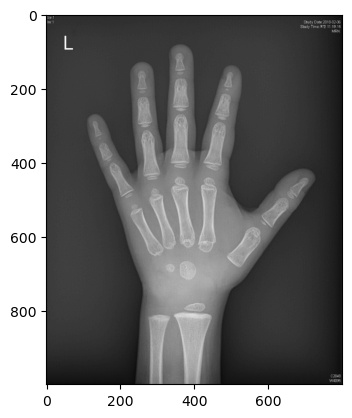

In [7]:
#resized 이미지 확인
plt.imshow(resized_img,"gray")

### Normalize

In [8]:
#이미지 min max 정규화
normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

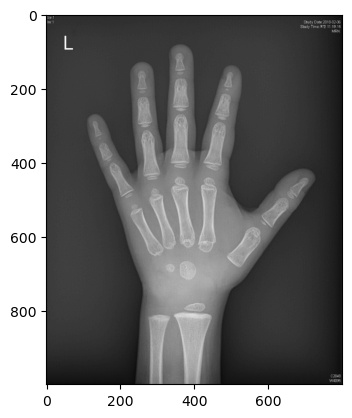

In [9]:
#normalized 이미지 확인
plt.imshow(normal_img,"gray")

### Denoise

In [10]:
#이미지 노이즈 제거
    #제거 강도: 20
    #templateWindowSize :5
    #searchWindowSize : 15
denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 10, 5, 15)

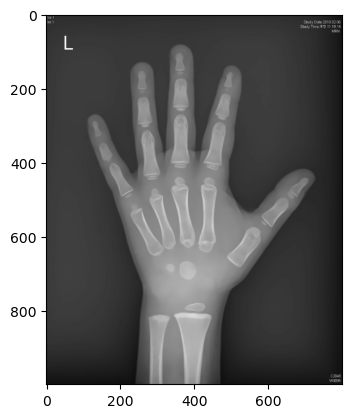

In [11]:
#denoised 이미지 확인
plt.imshow(denoise_img,"gray")

### Equalize

In [12]:
#이미지 평탄화
    #cv2.equalizeHist 사용시 전체 기준이므로 contrast가 날아가는 문제 발생
    #따라서 bin 구간 나누어 평탄화 가능한 clahe로 평탄화 수행
    #clipLimit: 2
    #tileGridSize: 5 x 5
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
equal_img=clahe.apply(denoise_img)

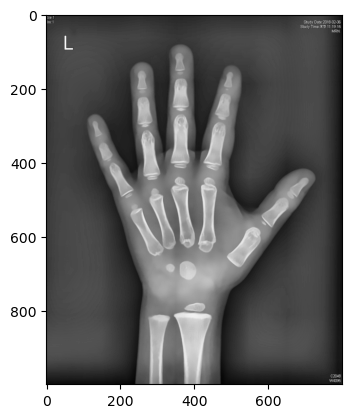

In [13]:
#equalized 이미지 확인
plt.imshow(equal_img,"gray")

### 전체 이미지 전처리 수행

In [14]:
#dataframe에 전처리한 이미지 데이터 넣고 저장

img_lst=[]
for i in range(0,len(df)):
    gend="M" if df.Gender[i]==0 else "F"
    img_path=glob.glob(data_path+"images/"+str(df.ID[i])+"_"+gend+".jpg")
    
    if len(img_path)>0:
        img_path=img_path[0]
    else:
        img_path=glob.glob(data_path+"images/"+str(df.ID[i]).zfill(3)+"_"+gend+".jpg")[0]
    
    img_name=img_path[0:-4]+"_pf.jpg"
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    
    #이미지 사이즈 재설정
    resized_img=cv2.resize(img,(800,1000))
    
    #이미지 min max 정규화
    normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    
    #이미지 노이즈 제거
    denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 20, 5, 15)
    
    #이미지 평탄화
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
    equal_img=clahe.apply(denoise_img)
    
    #이미지 저장
    cv2.imwrite(img_name,equal_img)
    
    #리스트에 이미지 경로 추가
    img_lst.append(img_name)
    
#dataframe 저장
data=pd.concat([df,pd.Series(img_lst,name="Img")],axis=1)
data.to_csv(data_path+"img_df.csv",index=False)

# 3. 이미지 회전

(1,2번 수행한 경우 여기부터 수행)  
중지를 기준으로 이미지 회전이 필요함

### 데이터 불러오기

In [15]:
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

data=pd.read_csv(data_path+"img_df.csv")
data.head()

,ID,BoneAge,Gender,Img
0,541,16.000,1,/Users/eunha/Desktop/골밀도데이터/BoneAgeDat...
1,542,15.250,1,/Users/eunha/Desktop/골밀도데이터/BoneAgeDat...
2,543,15.250,1,/Users/eunha/Desktop/골밀도데이터/BoneAgeDat...
3,544,15.875,1,/Users/eunha/Desktop/골밀도데이터/BoneAgeDat...
4,545,15.000,1,/Users/eunha/Desktop/골밀도데이터/BoneAgeDat...


### 이미지 회전 함수

In [16]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

###  샘플 이미지 선정

회전 결과를 확인하기 위해 샘플 이미지 임의 선정

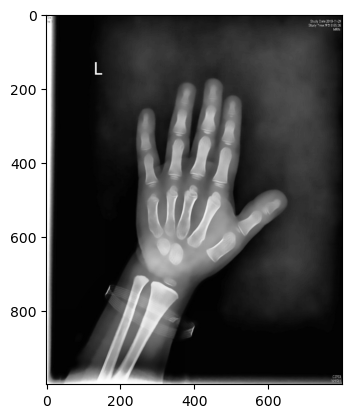

In [17]:
img0=cv2.imread("/Users/eunha/Desktop/골밀도데이터/BoneAgeData/images/009_M_pf.jpg",cv2.IMREAD_GRAYSCALE)

#샘플 이미지 확인
plt.imshow(img0,"gray")

### 샘플이미지 Thresholding

threshold 이하는 0으로, 이상은 255로 설정

In [18]:
r_img = np.copy(img0)
height, width = img0.shape
img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
ret, img = cv2.threshold(img, img0.mean()*0.99, 255, cv2.THRESH_BINARY)
    

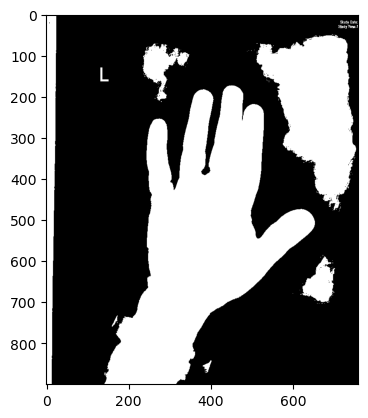

In [19]:
#샘플 이미지 Thresholding 결과
plt.imshow(img,"gray")

### 이미지 contouring

이진화된 이미지에서 테두리 추출  
cv2.RETR_EXTERNAL: 바깥쪽의 라인 추출  
cv2.CHAIN_APPROX_SIMPLE: 컨투어 라인 포인트만 반환

In [20]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#외곽선 검출하여 mask 그리기
max_cnt = max(contours, key=cv2.contourArea)

mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

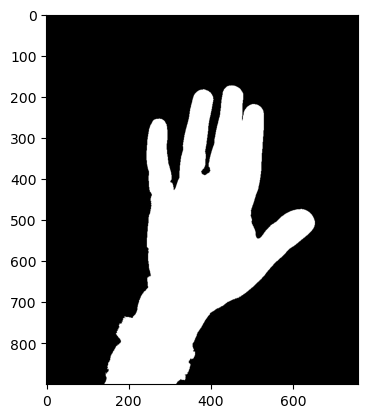

In [21]:
#샘플 이미지 contouring 결과
plt.imshow(mask,"gray")

### 이미지 Dilation

dilation을 통해 뼈 부분 팽창

In [22]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
mask = cv2.dilate(mask,k)

#dilation 후 컨투어 외곽선 다시 추출
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key=cv2.contourArea)

### 첫번째 흰색 좌표 구하기

골밀도 x-ray 이미지 특성상 첫번째 흰색 좌표가 중지 끝일 가능성이 큼

In [23]:
M = cv2.moments(max_cnt)
center = ( int(M['m10'] / M['m00']), int(M['m01'] / M['m00']) )

for y,x_r in enumerate(mask) :
    if 255 in x_r:
        #y에 따른 x rows 중 255인 x값 추출
        x_255_indexs = np.where(x_r == 255)[0]

        #255인 x값들 중 median 추출
        x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
        first_255_x_point = x_255_mid_index

        first_255_y_point = y
        break
        
print((first_255_x_point,first_255_y_point))

(451, 171)


### 중심점 기준 각도 구하여 회전시키기

In [24]:
#중심점의 좌표 기준 첫 흰색 좌표와 차이 구하기
half_h, half_w = center[1], center[0]
ry = half_h-first_255_y_point 
rx = abs(first_255_x_point-half_w)

#차이 이용하여 회전 각도 구하기
radian = math.atan2(ry,rx)
degree = 90 - (radian * 180 / math.pi)
print("회전각도 : ", degree)

#각도가 3 이상인 경우 회전시키기 
if degree > 3:
    
    #중심점 좌표와 첫 흰색 좌표 위치에 따라 회전 방향 조정
    if first_255_x_point < half_w :
        mask = rotate_image(mask,360-degree) 
        r_img_ = rotate_image(img0,360-degree)
    else:
        mask = rotate_image(mask,degree) 
        r_img_ = rotate_image(img0,degree) 


회전각도 :  11.663969860003476


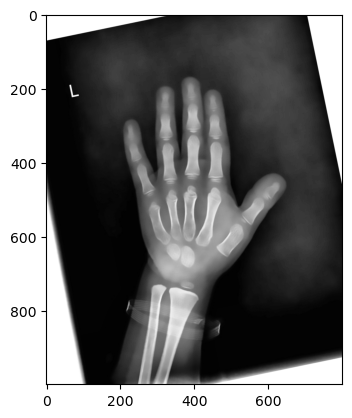

In [25]:
#샘플 이미지 회전 결과
plt.imshow(r_img_,"gray")

In [26]:
data.Img[1][:-6]+"rotate.jpg"

'/Users/eunha/Desktop/골밀도데이터/BoneAgeData/images/542_F_rotate.jpg'

### 전체 이미지 회전

In [32]:
rotate_img=[]
for i in range(0,len(data)):
    
    img0=cv2.imread(data.Img[i],cv2.IMREAD_GRAYSCALE)
    rotate_name=data.Img[i][:-6]+"rotate.jpg"
    
    #이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean()*0.99, 255, cv2.THRESH_BINARY)
    
    
    #이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    #이미지 dilation
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)

    #dilation 후 컨투어 외곽선 다시 추출
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    
    #중지 끝 좌표 구하기
    M = cv2.moments(max_cnt)
    center = ( int(M['m10'] / M['m00']), int(M['m01'] / M['m00']) )

    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
    
    #중심점의 좌표 기준 첫 흰색 좌표와 차이 구하기
    half_h, half_w = center[1], center[0]
    ry = half_h-first_255_y_point 
    rx = abs(first_255_x_point-half_w)

    #차이 이용하여 회전 각도 구하기
    radian = math.atan2(ry,rx)
    degree = 90 - (radian * 180 / math.pi)

    #각도가 3 이상인 경우 회전시키기 
    if degree > 3:

        #중심점 좌표와 첫 흰색 좌표 위치에 따라 회전 방향 조정
        if first_255_x_point < half_w :
            mask = rotate_image(mask,360-degree) 
            r_img_ = rotate_image(img0,360-degree)
        else:
            mask = rotate_image(mask,degree) 
            r_img_ = rotate_image(img0,degree) 

    
    #이미지 저장
    cv2.imwrite(rotate_name,r_img_)
    
    #리스트에 이미지 경로 추가
    rotate_img.append(rotate_name)
    
#dataframe 저장
r_data=pd.concat([data,pd.Series(rotate_img,name="Rotate_Img")],axis=1)
r_data.to_csv(data_path+"rotate_df.csv",index=False)

# 4. Train, Test set split

(1,2,3번 수행한 경우 여기부터 수행)

### 저장한 label, 이미지 데이터 불러오기

In [29]:
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

data=pd.read_csv(data_path+"rotate_df.csv")
print(data)

       ID  BoneAge  Gender                                                Img  \
0     541   16.000       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
1     542   15.250       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
2     543   15.250       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
3     544   15.875       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
4     545   15.000       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
...   ...      ...     ...                                                ...   
1232  205    8.000       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
1233  206    7.500       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
1234  207    7.625       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
1235  208    9.875       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   
1236  209    9.250       1  /Users/eunha/Desktop/골밀도데이터/BoneAgeDat...   

                           

### 데이터 split

In [30]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state = 42, stratify = data["Gender"])

#df 저장
train_df.to_csv(data_path+"train_df.csv",index=False)
test_df.to_csv(data_path+"test_df.csv",index=False)